In [1]:
%load_ext memory_profiler

In [2]:
import numpy as np
import os
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import h5py
import tables
import pandas as pd
import random
from scipy.signal import find_peaks

In [3]:
matplotlib.rc('font', size=16)          # controls default text sizes
matplotlib.rc('axes', titlesize=16)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=16)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=16)    # legend fontsize
matplotlib.rc('figure', titlesize=16)  # fontsize of the figure title
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.facecolor'] = 'w'
matplotlib.rc('figure.subplot', hspace=  0.4)
fs = 1/2e-9
def process_data(trace, recordlength):
    try:
        traceR = trace.reshape(int(np.floor(len(trace)/recordlength)),recordlength)
    except ValueError:
        trace = trace[:int(np.floor(len(trace)/recordlength))*recordlength,]
        traceR = trace.reshape(int(np.floor(len(trace)/recordlength)),recordlength)
    data= traceR-np.expand_dims(traceR[:,100:2000].mean(axis=1), axis=1)
#     print ('input trace length',trace.shape, 'processed trace shape',  data.shape)
    return data
def create_template(traces):
    template = np.mean(traces, axis = 0)
    template_norm= -template/min(template)
    return template,template_norm

def clippedwaveformsindex(data, clippingstart = -15100):
    clippedIdx = []
    data_max_idx = np.argmin(data, axis=1) 
    for i in range(len(data)):
        if data[i][data_max_idx[i]] < clippingstart:
            clippedIdx.append(i)
    return clippedIdx


def glitchesindex(data, threshold = 5):
    glitchesIdx = []
    
    std = ((data[:, 100:1000].std(axis=1)).reshape(len(data),1))
    t0idx = np.argmax(data<-(10*std), axis=1)   
        
    data_max_idx = np.argmin(data, axis=1)
    
    for i in range(len(data)):
        if data_max_idx[i] - t0idx[i] < threshold:
            glitchesIdx.append(i)
    return glitchesIdx


def pileupindex(data, ctype):
    pileupIdx, noisyIdx = [], []

    energy = np.sum(data/np.min(data, axis =1)[:, None], axis =1)
    
    if ctype == 'pure': distancefactor, prominencefactor = 15,  0.085
    else: distancefactor, prominencefactor = 200, 0.4
    if ctype == 'pure': threshold_min, threshold_max = 15,40
    else: threshold_min, threshold_max = 350,900
        
    data_max_idx = np.argmin(data, axis=1)
    data_max = data[np.arange(len(data_max_idx)),data_max_idx]  
    for i in range(0, len(data)):
        peaks, peak_properties = find_peaks(-data[i], prominence =(-data_max[i]*prominencefactor), distance=distancefactor)
        if len(peaks)>1 :
            pileupIdx.append(i)
        if energy[i] > threshold_max or energy[i] < threshold_min:
            noisyIdx.append(i)
    return pileupIdx, noisyIdx

def OF_calct0(signal, template_norm, psd_noise, fs, recordlength):
    amp, t0, chi2= [], [], []
    for trace in np.arange(len(signal)):
        OF = qp.OptimumFilter(signal[trace], template_norm, psd_noise, fs) # initialize the OptimumFilter class
        amp_withdelay, t0_withdelay, chi2_withdelay= OF.ofamp_withdelay() # t0_withdelay : time shift calculated for the pulse (in s).
        amp.append(amp_withdelay)
        t0.append(t0_withdelay)
        chi2.append(chi2_withdelay)
    return amp, t0, chi2
templateEM_Tl,  TemplateEM_Tl = create_template(np.load('templates/Tl_template_pulses.npy'))
templateHAD_Tl,  TemplateHAD_Tl = create_template(np.load('templates/Tl_template_pulses_neutron.npy'))

templateEM_p,  TemplateEM_p = create_template(np.load('templates/pure_template_pulses.npy'))
templateHAD_p,  TemplateHAD_p = create_template(np.load('templates/pure_template_pulses_neutron.npy'))

fs =1/2e-9

 
# energy in [ADC] / energyfactor = energy in [MeV]
'''energyfactor_pure 6243
energyfactor_Tl 118252

longtime_pure 250
shorttime_pure 24

longtime_Tl 11000
shorttime_Tl 600'''
def Ecalibration (amp, ctype):
    if ctype == 'Tl':
        return amp/118252
    if ctype == 'pure':
        return amp/6243

5611539


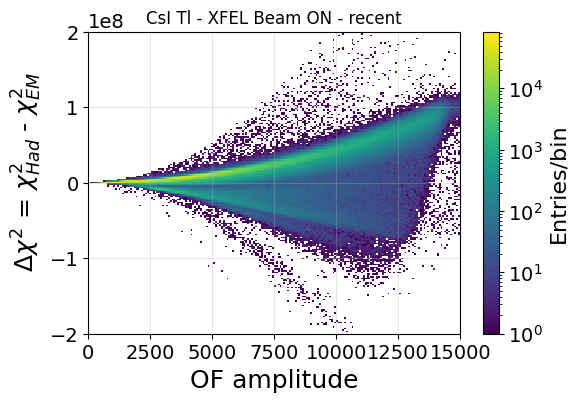

5383957


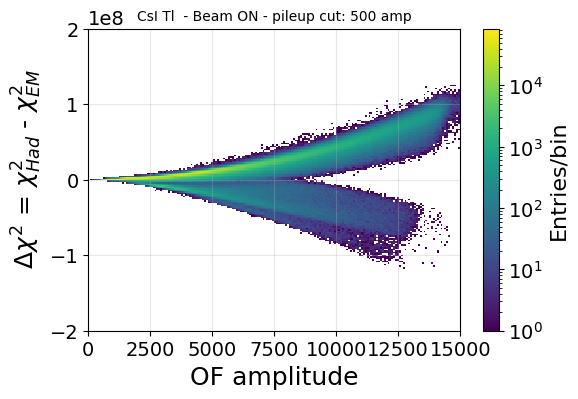

In [13]:

XFEL_Tl = h5py.File('saved_outputs/Tl_XFEL_beamON.hdf5')




gli= np.where(XFEL_Tl['glitch'][:]==True)[0]
clip= np.where(XFEL_Tl['clipped'][:]==True)[0]
pileup= np.where(XFEL_Tl['pileup'][:]==True)[0]
noisy= np.where(XFEL_Tl['noisypulse'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy),0))
# select = []


XFEL_Tl_amp = np.delete(XFEL_Tl ['amp_withdelay_EM'][:],select)
XFEL_Tl_deltachi2=np.delete(np.array(XFEL_Tl ['Delta_chi2']), select)
CR_Tl_XFEL = np.delete(np.array(XFEL_Tl ['charge_ratio']), select)
integrated_raw_amp_Tl_XFEL = np.delete(np.array(XFEL_Tl ['integrated_raw_amp']), select)
XFEL_Tl_t0pil = np.delete(XFEL_Tl['t0_pileup_EM'][:],select)


print (len(XFEL_Tl_amp))
# plt.figure(figsize=(6, 4))
# plt.subplot(2,2,1)
plt.hist2d(XFEL_Tl_amp, XFEL_Tl_deltachi2,bins=(np.linspace(0,15200,200),np.linspace(-0.2e9, 0.2e9, 200)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI Tl - XFEL Beam ON - recent', fontsize =12)
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
plt.show()



# plt.subplot(2,2,2)
# plt.hist2d(Ecalibration(integrated_raw_amp_Tl_XFEL, 'Tl'), XFEL_Tl_deltachi2,bins=(np.linspace(0,100,200),np.linspace(-0.2e9, 0.2e9, 200)), cmin=1, norm=LogNorm())
# plt.xlabel(r'Energy [MeV]',fontsize=18)
# plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# plt.xlim(0,90)
# plt.grid(alpha=0.3)
# plt.title('CsI Tl - XFEL Beam ON -recent')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# # plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_Energy.png',bbox_inches = 'tight')
# plt.show()



_XFEL_Tl_amp = np.array(XFEL_Tl ['amp_withdelay_EM'][:])
_XFEL_Tl_t0pil = np.array(XFEL_Tl['t0_pileup_EM'][:])
_XFEL_Tl_amppil = np.array(XFEL_Tl['amp_pileup_EM'][:])
_XFEL_Tl_t0pil_ = np.array(XFEL_Tl['t0_pileup_Had'][:])
_XFEL_Tl_amppil_ = np.array(XFEL_Tl['amp_pileup_Had'][:])
_XFEL_Tl_deltachi2=np.array(XFEL_Tl ['Delta_chi2'])



gli= np.where(XFEL_Tl['glitch'][:]==True)[0]
clip= np.where(XFEL_Tl['clipped'][:]==True)[0]
pileup= np.where(XFEL_Tl['pileup'][:]==True)[0]
noisy= np.where(XFEL_Tl['noisypulse'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy),0))
# select = []


select2 = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]>0 and  abs(_XFEL_Tl_amppil[i] )>500]
select3 = [i for i in range (len(_XFEL_Tl_amp)) if _XFEL_Tl_deltachi2[i]<0 and abs(_XFEL_Tl_amppil_[i] )>600]
select = list(set(list(select)+ select3+select2))


XFEL_Tl_amp_1 = np.delete(XFEL_Tl ['amp_withdelay_EM'][:],select)

integrated_raw_amp_Tl_XFEL_1 = np.delete(np.array(XFEL_Tl ['integrated_raw_amp']), select)
XFEL_Tl_deltachi2_1=np.delete(np.array(XFEL_Tl ['Delta_chi2']), select)
CR_Tl_XFEL_1 = np.delete(np.array(XFEL_Tl ['charge_ratio']), select)
XFEL_Tl_t0pil_1 = np.delete(XFEL_Tl['t0_pileup_EM'][:],select)

print (len(XFEL_Tl_amp_1))


# plt.figure(figsize=(20, 12))
# plt.subplot(2,2,1)
plt.hist2d(XFEL_Tl_amp_1, XFEL_Tl_deltachi2_1,bins=(np.linspace(0,15200,200),np.linspace(-0.2e9, 0.2e9, 200)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI Tl  - Beam ON - pileup cut: 500 amp',fontsize=10)
cbar = plt.colorbar()
cbar.set_label('Entries/bin')


# plt.subplot(2,2,2)
# plt.hist2d(Ecalibration(integrated_raw_amp_Tl_XFEL_1, 'Tl'), XFEL_Tl_deltachi2_1,bins=(np.linspace(0,100,200),np.linspace(-0.2e9, 0.2e9, 200)), cmin=1, norm=LogNorm())
# plt.xlabel(r'Energy [MeV]',fontsize=18)
# plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
# plt.xlim(0,90)
# plt.grid(alpha=0.3)
# plt.title('CsI Tl - XFEL Beam ON - finetuned')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# # plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_Energy.png',bbox_inches = 'tight')
# plt.show()


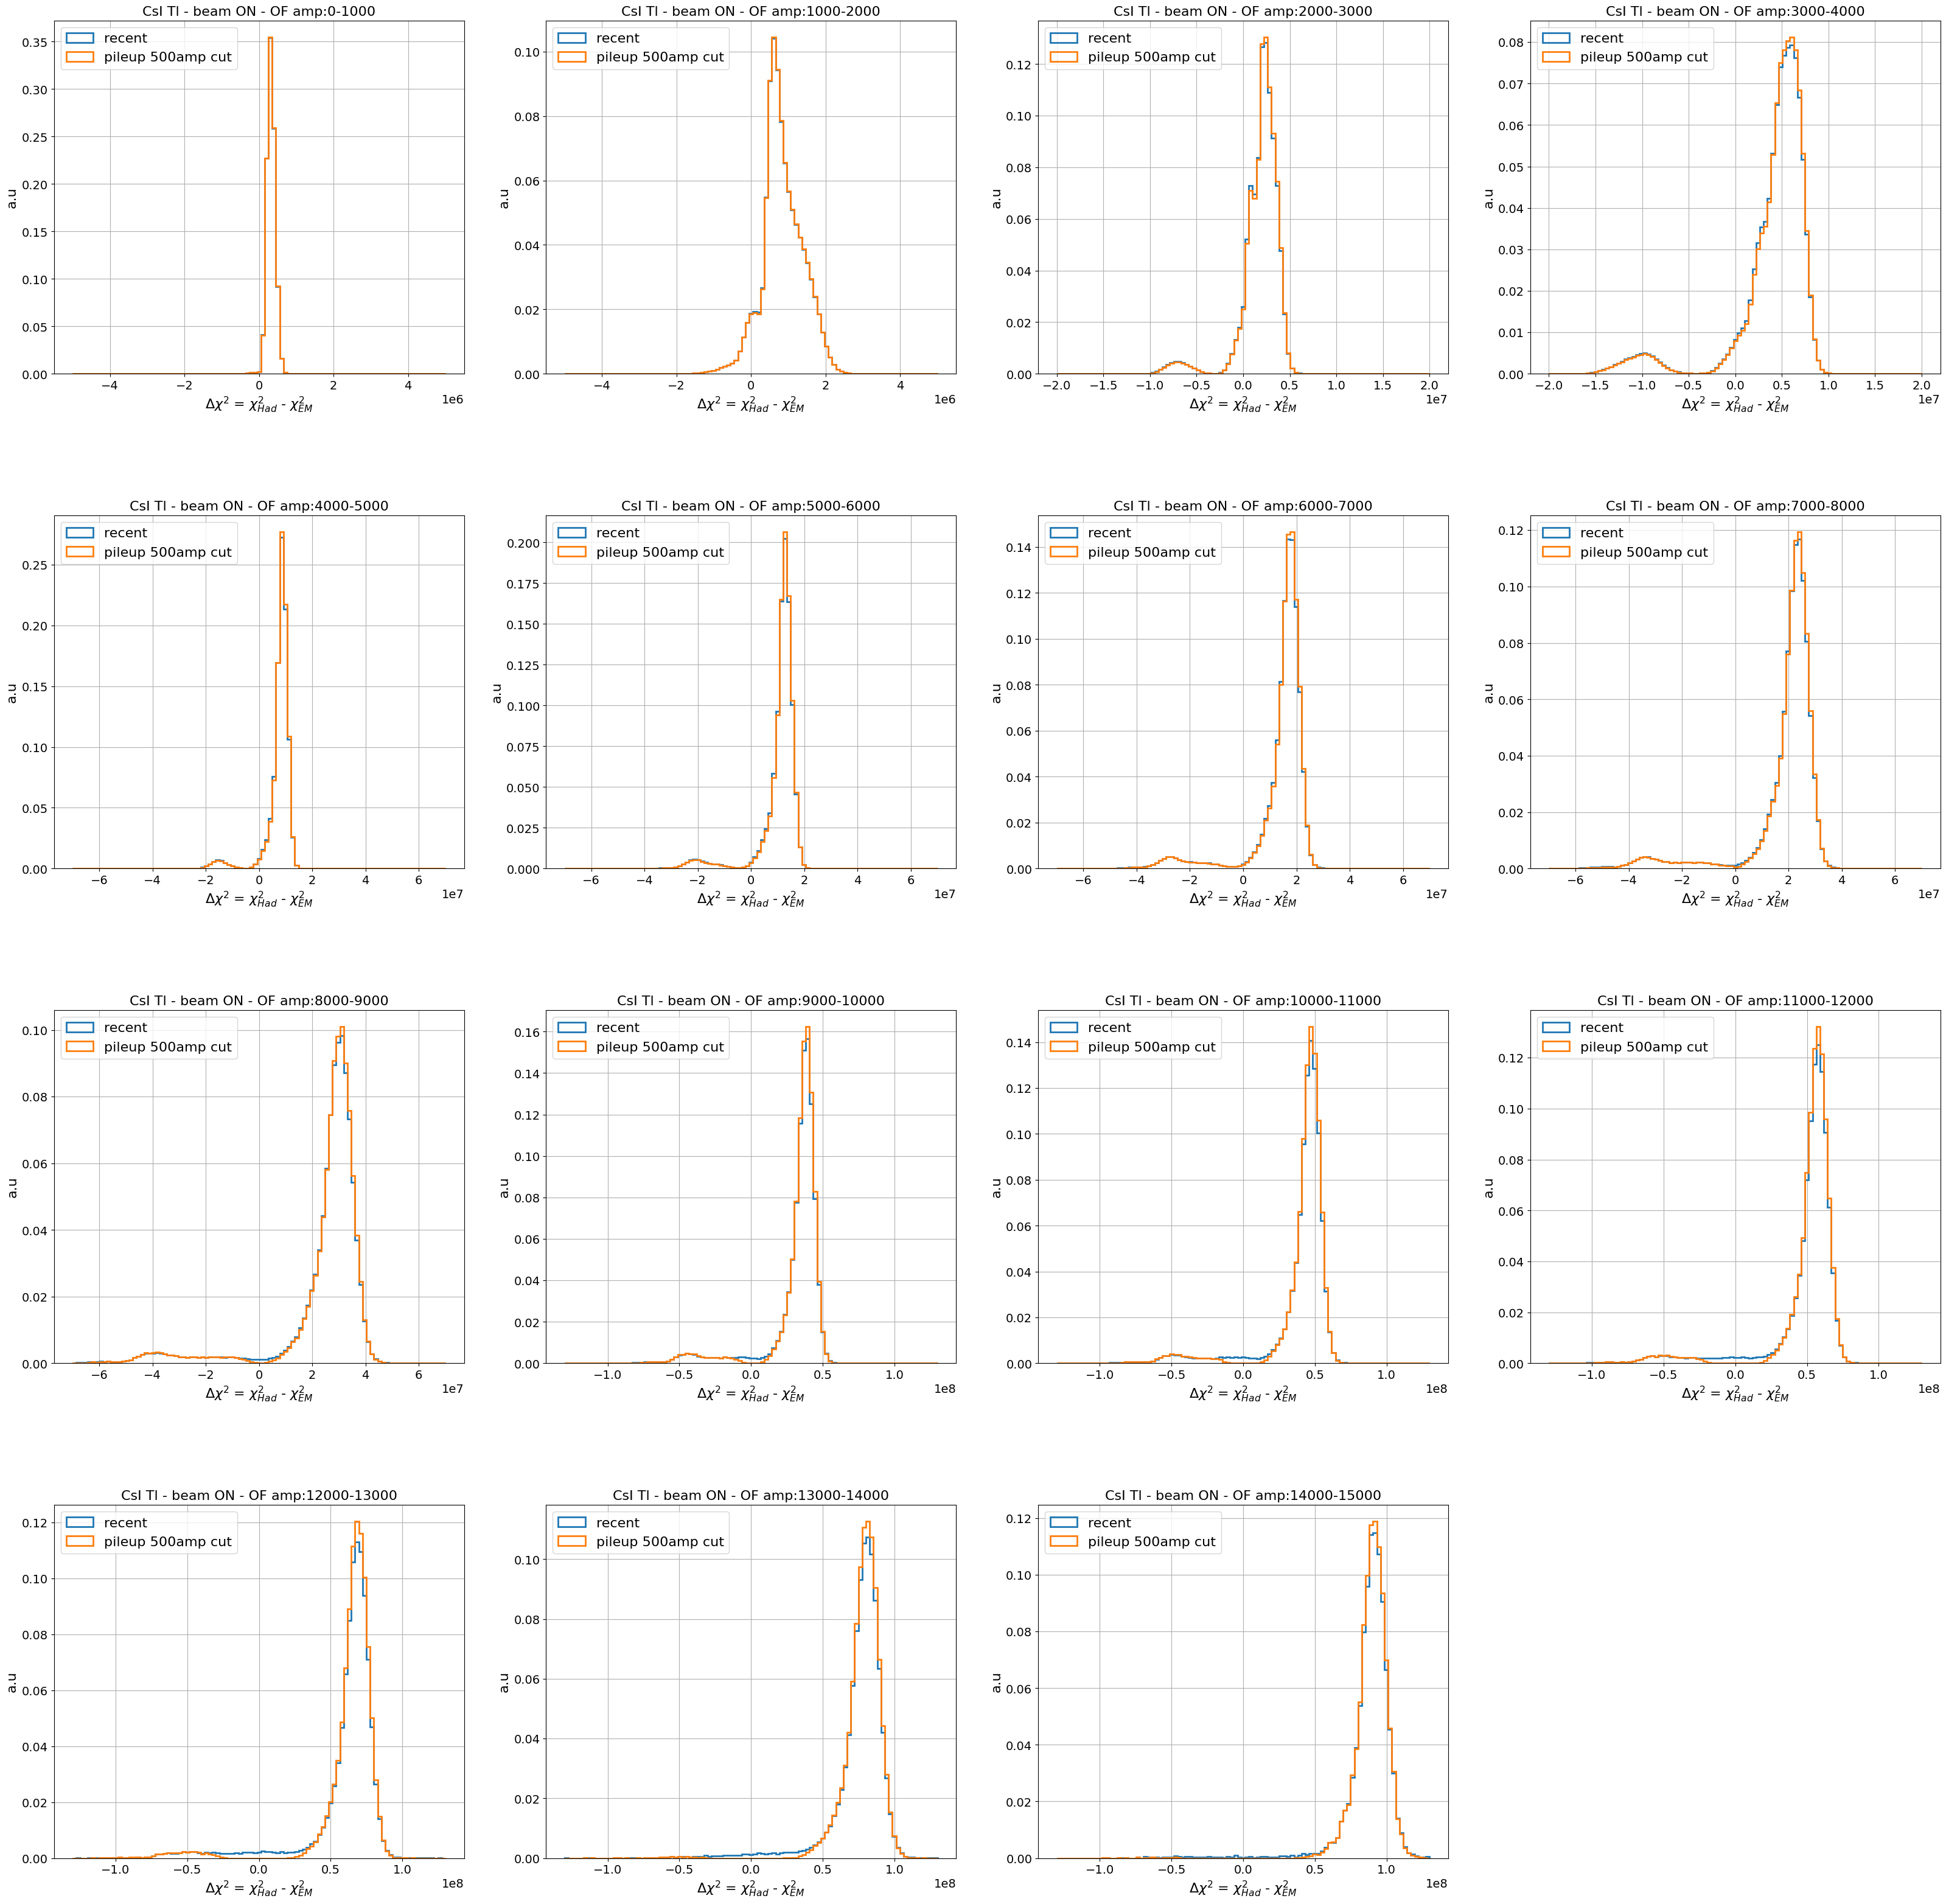

In [14]:



slices=np.arange(0,15000,1000)
fig, ax = plt.subplots(4, 4, figsize=(40,40))
ax = ax.flatten()
ax[-1].axis('off')#; ax[-2].axis('off')
for i, s in enumerate(slices):
    sl = [i for i, x in enumerate(XFEL_Tl_amp) if x>s and x<s+1000]
    bins = np.linspace(-1e8,1e8,100)
    if s  < 2000: bins = np.linspace(-0.05e8,0.05e8,100)
    elif s  < 4000: bins = np.linspace(-0.2e8,0.2e8,100)
    elif s  < 9000: bins = np.linspace(-0.7e8,0.7e8,100)
    else: bins = np.linspace(-1.3e8,1.3e8,100)
    weights = np.ones_like(np.take(XFEL_Tl_deltachi2,sl))/len(np.take(XFEL_Tl_deltachi2,sl))
    ax[i].hist(np.take(XFEL_Tl_deltachi2,sl), bins =bins,  histtype = 'step', weights = weights, linewidth = 2, label = 'recent')
    sl = [i for i, x in enumerate(XFEL_Tl_amp_1) if x>s and x<s+1000]
    weights = np.ones_like(np.take(XFEL_Tl_deltachi2_1,sl))/len(np.take(XFEL_Tl_deltachi2_1,sl))
    ax[i].hist(np.take(XFEL_Tl_deltachi2_1,sl), bins =bins,  histtype = 'step', weights = weights, linewidth = 2, label = 'pileup 500amp cut')
    ax[i].set_title('CsI Tl - beam ON - OF amp:'+str(s)+'-'+str(s+1000))
    ax[i].set_xlabel(r'$\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$')
    ax[i].set_ylabel('a.u')
    ax[i].grid()
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[i].legend(loc = 'upper left')
plt.show()


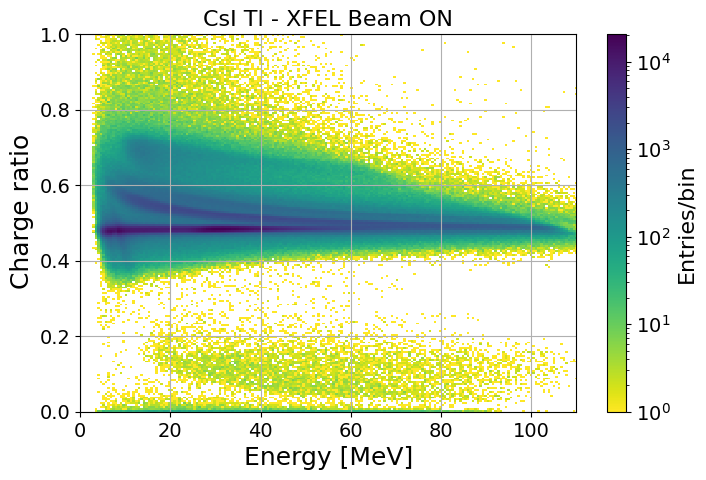

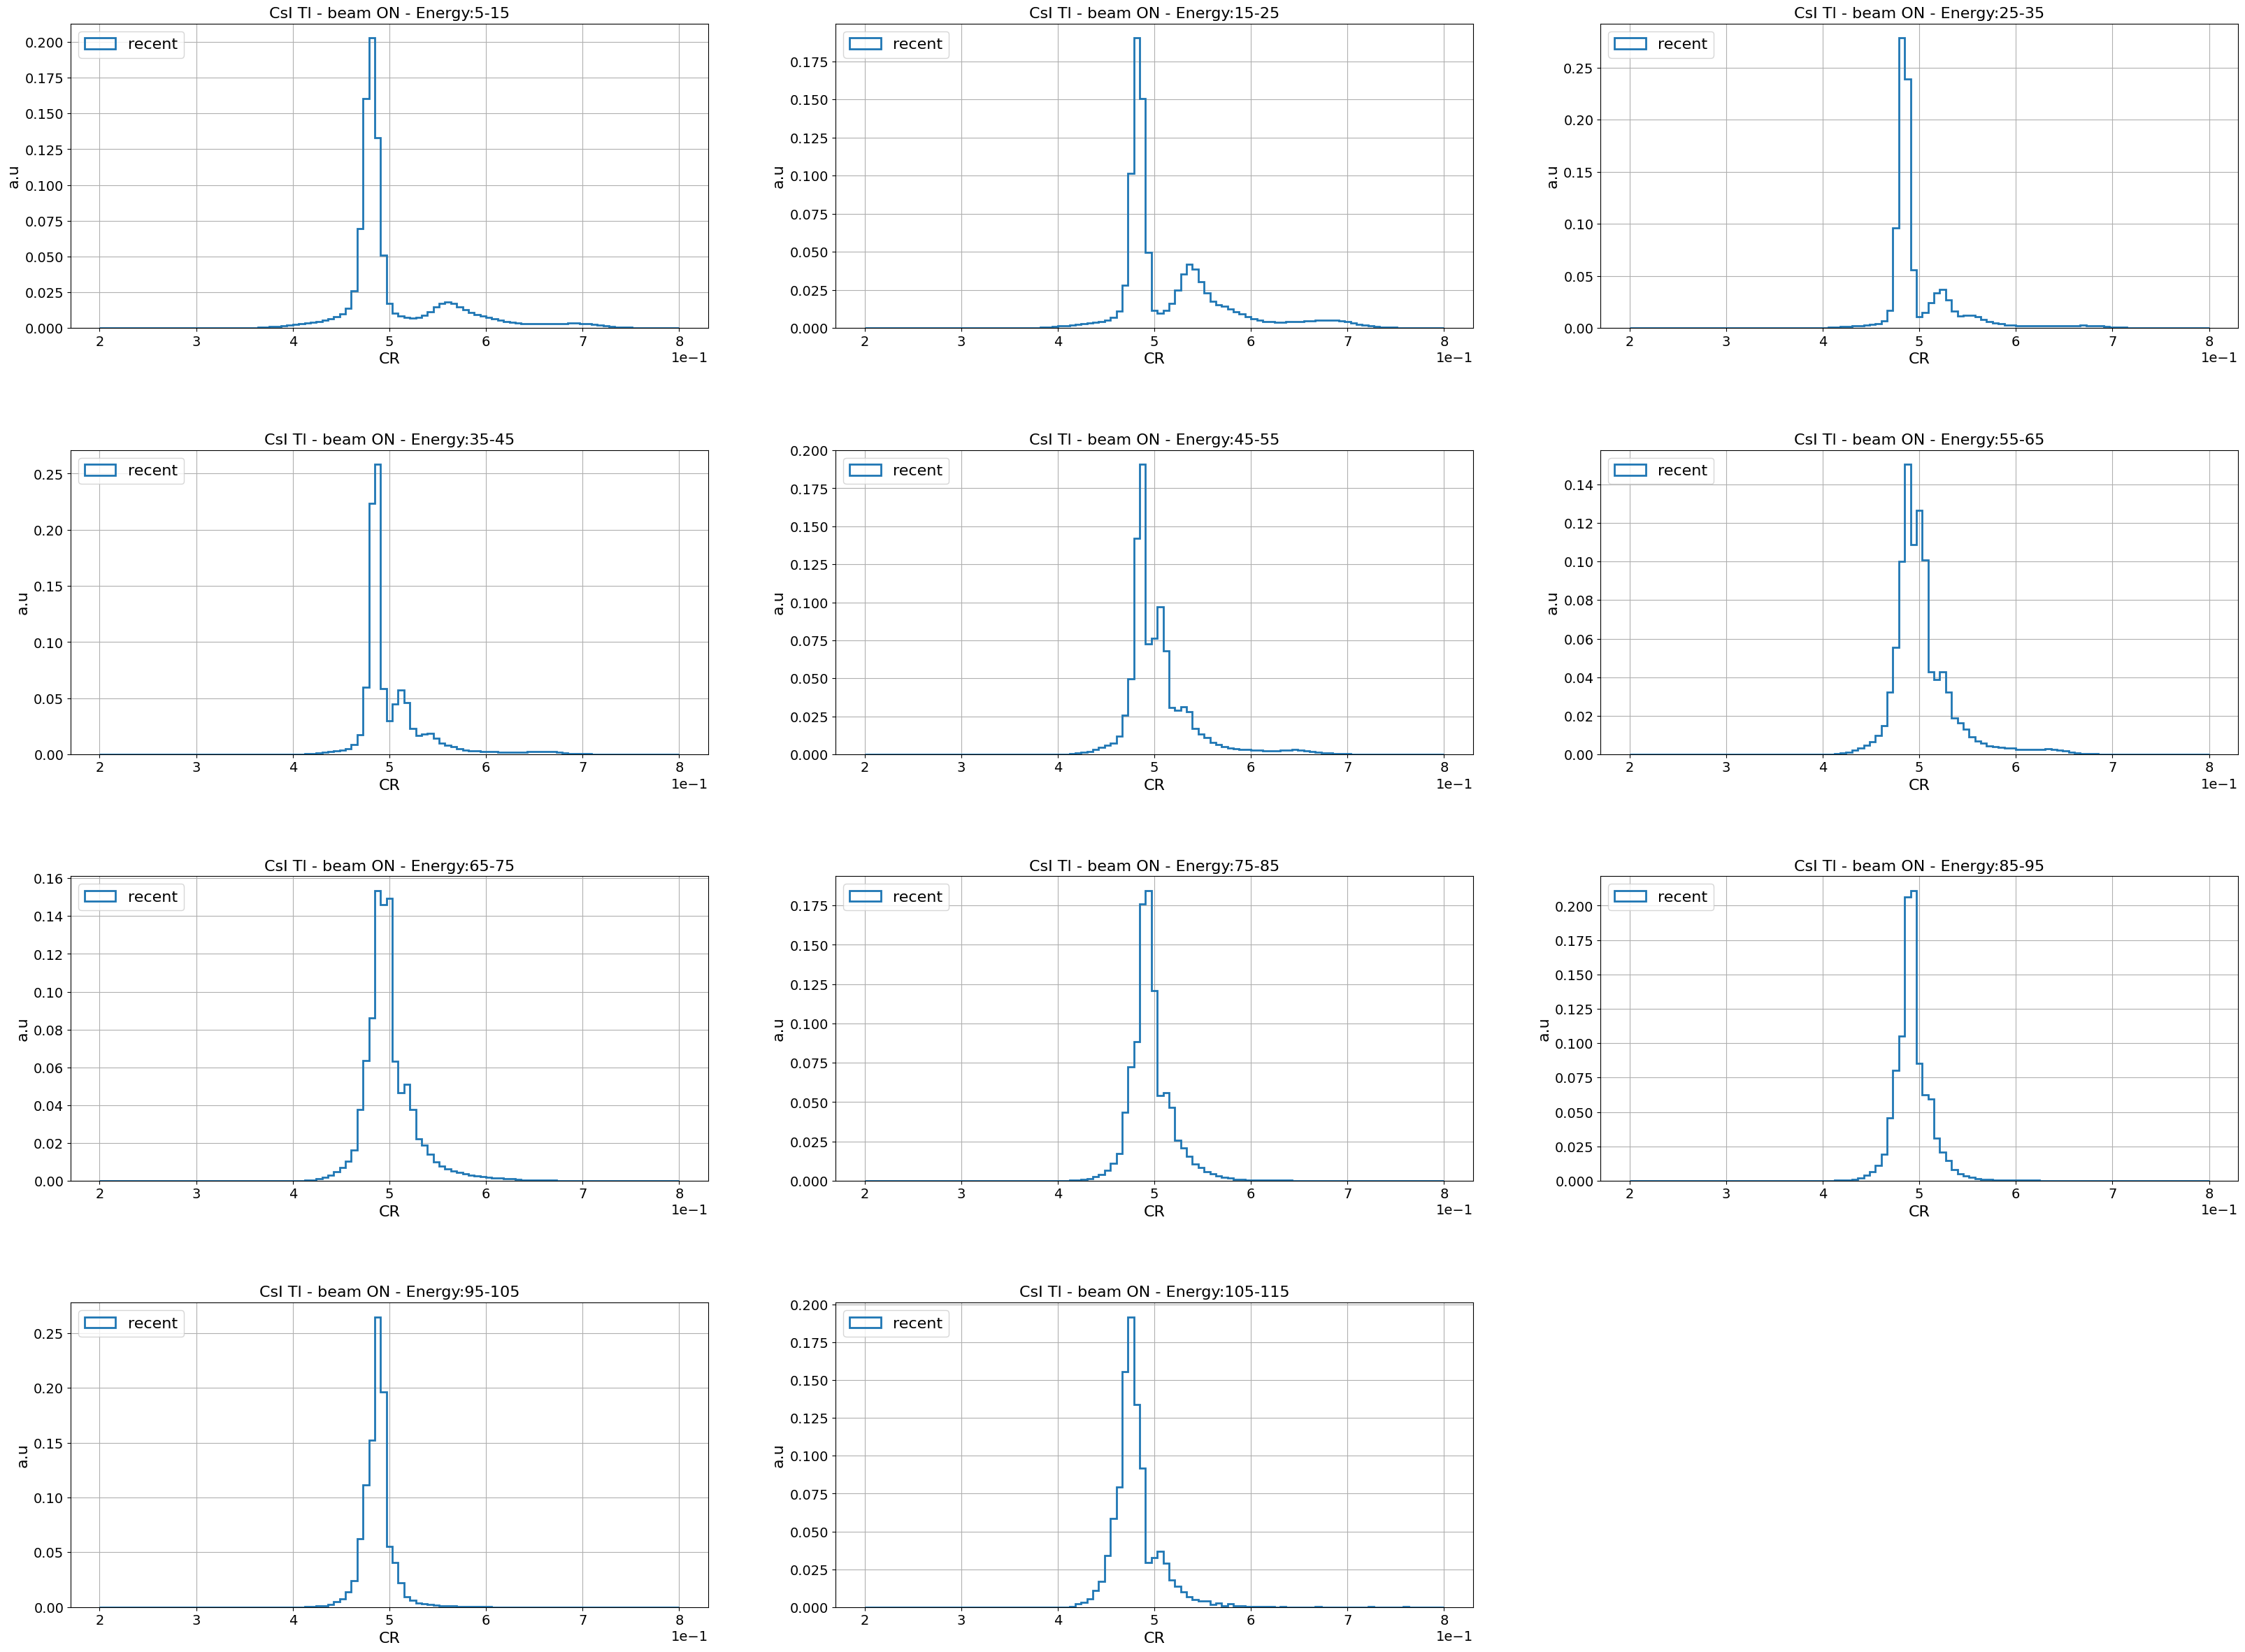

In [51]:
E =Ecalibration(integrated_raw_amp_Tl_XFEL, 'Tl')
plt.figure(figsize=(8, 5))
plt.hist2d(XFEL_Tl_amp, CR_Tl_XFEL,bins=(200, np.linspace(0,1,200)),cmap='viridis_r', cmin=1, norm=LogNorm())
plt.xlabel(r'Energy [MeV]',fontsize=18)
plt.ylabel(r'   Charge ratio',fontsize=18)
plt.xlim(0,110)
plt.grid()
plt.title('CsI Tl - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_Energy.png',bbox_inches = 'tight')
plt.show()

# plt.figure(figsize=(8, 5))
# plt.hist2d(Ecalibration(integrated_raw_amp_Tl_XFEL_1, 'Tl'), CR_Tl_XFEL_1,bins=(200, np.linspace(0,1,200)),cmap='viridis_r', cmin=1, norm=LogNorm())
# plt.xlabel(r'Energy [MeV]',fontsize=18)
# plt.ylabel(r'   Charge ratio',fontsize=18)
# plt.xlim(0,90)
# plt.grid()
# plt.title('CsI Tl - XFEL Beam ON')
# cbar = plt.colorbar()
# cbar.set_label('Entries/bin')
# # plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_Energy.png',bbox_inches = 'tight')
# plt.show()



slices=np.arange(5,115,10)
fig, ax = plt.subplots(4, 3, figsize=(40,30))
ax = ax.flatten()
ax[-1].axis('off')
for i, s in enumerate(slices):
    sl = [i for i, x in enumerate(E) if x>s and x<s+10]
    bins = np.linspace(0.2, 0.8,100)
#     if s  < 4000: bins = np.linspace(-0.3e8,0.3e8,100)
#     elif s  < 9000: bins = np.linspace(-0.7e8,0.7e8,100)
#     else: bins = np.linspace(-1.3e8,1.3e8,100)
    weights = np.ones_like(np.take(CR_Tl_XFEL,sl))/len(np.take(CR_Tl_XFEL,sl))
    ax[i].hist(np.take(CR_Tl_XFEL,sl), bins =bins,  histtype = 'step', weights = weights, linewidth = 2, label = 'recent')
    sl = [i for i, x in enumerate(XFEL_Tl_amp_1) if x>s and x<s+1000]
    weights = np.ones_like(np.take(XFEL_Tl_deltachi2_1,sl))/len(np.take(XFEL_Tl_deltachi2_1,sl))
#     ax[i].hist(np.take(XFEL_Tl_deltachi2_1,sl), bins =bins,  histtype = 'step', weights = weights, linewidth = 2, label = 'finetuned')
    ax[i].set_title('CsI Tl - beam ON - Energy:'+str(s)+'-'+str(s+10))
    ax[i].set_xlabel(r'CR')
    ax[i].set_ylabel('a.u')
    ax[i].grid()
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[i].legend(loc = 'upper left')
plt.show()

7163151
5384155
3934046


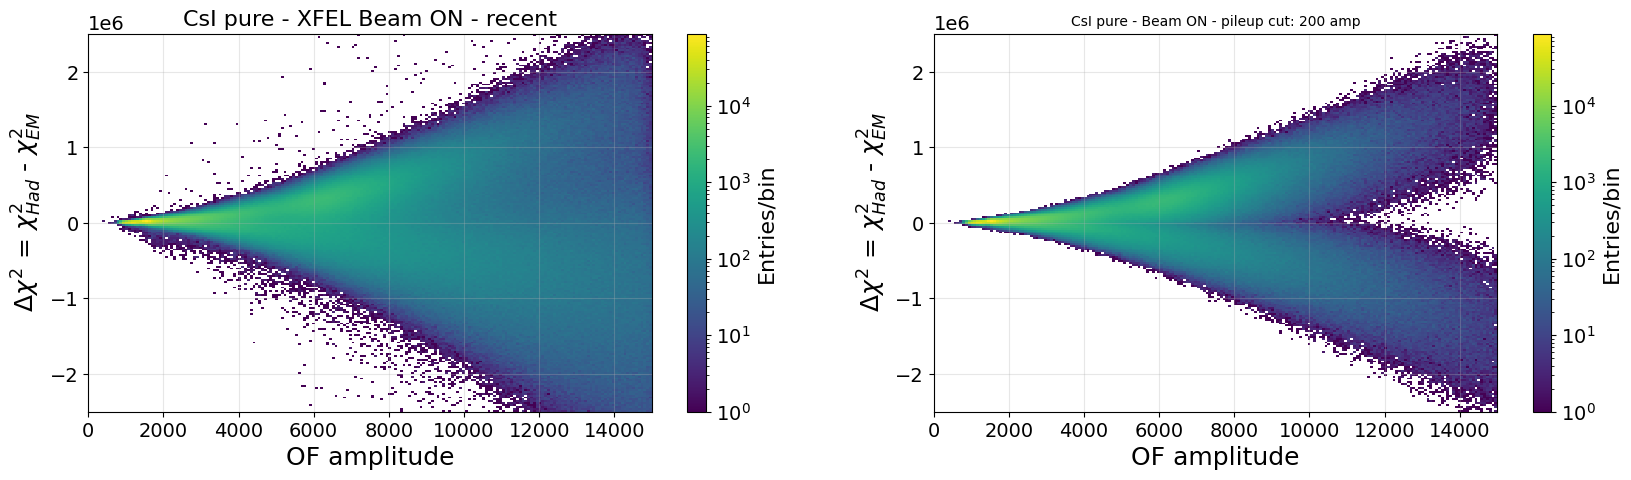

In [10]:

XFEL_p = h5py.File('saved_outputs/pure_XFEL_beamON.hdf5')

print(len(XFEL_p ['amp_withdelay_EM'][:]))
gli= np.where(XFEL_p['glitch'][:]==True)[0]
clip= np.where(XFEL_p['clipped'][:]==True)[0]
pileup= np.where(XFEL_p['pileup'][:]==True)[0]
noisy= np.where(XFEL_p['noisypulse'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy),0))
# select = []

# select3 = [i for i in range (len(XFEL_p_amp)) if abs(XFEL_p_t0pil[i]*fs) > 350 and abs(XFEL_p_amppil[i] )>400 or abs(XFEL_p_amppil[i] )>1000]
# print('sel3', len(select3))
# select = list(set(list(select)+ select3))


XFEL_p_amp = np.delete(XFEL_p ['amp_withdelay_EM'][:],select)
XFEL_p_deltachi2=np.delete(np.array(XFEL_p ['Delta_chi2']), select)
integrated_raw_amp_p_XFEL = np.delete(np.array(XFEL_p ['integrated_raw_amp']), select)
CR_p_XFEL = np.delete(np.array(XFEL_p ['charge_ratio']), select)

print (len(XFEL_p_amp))


plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
plt.hist2d(XFEL_p_amp, XFEL_p_deltachi2,bins=(np.linspace(0,15000,200),np.linspace(-0.25e7, 0.25e7, 200)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.xlim(0,15000)
plt.grid(alpha=0.3)
plt.title('CsI pure - XFEL Beam ON - recent')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')





_XFEL_p_amp = np.array(XFEL_p ['amp_withdelay_EM'][:])
_XFEL_p_t0pil = np.array(XFEL_p['t0_pileup_EM'][:])
_XFEL_p_amppil = np.array(XFEL_p['amp_pileup_EM'][:])
_XFEL_p_t0pil_ = np.array(XFEL_p['t0_pileup_Had'][:])
_XFEL_p_amppil_ = np.array(XFEL_p['amp_pileup_Had'][:])
_XFEL_p_deltachi2=np.array(XFEL_p ['Delta_chi2'])



gli= np.where(XFEL_p['glitch'][:]==True)[0]
clip= np.where(XFEL_p['clipped'][:]==True)[0]
pileup= np.where(XFEL_p['pileup'][:]==True)[0]
noisy= np.where(XFEL_p['noisypulse'][:]==True)[0]
select = np.unique(np.concatenate((gli,clip,pileup,noisy),0))
# select = []

# select3 = [i for i in range (len(XFEL_p_amp)) if abs(XFEL_p_t0pil[i]*fs) > 350 and abs(XFEL_p_amppil[i] )>400 or abs(XFEL_p_amppil[i] )>1000]

select2 = [i for i in range (len(_XFEL_p_amp)) if _XFEL_p_deltachi2[i]>0 and  abs(_XFEL_p_amppil[i] )>200]
select3 = [i for i in range (len(_XFEL_p_amp)) if _XFEL_p_deltachi2[i]<0 and abs(_XFEL_p_amppil_[i] )>180]
select = list(set(list(select)+ select3+select2))

XFEL_p_amp_1 = np.delete(XFEL_p ['amp_withdelay_EM'][:],select)
XFEL_p_deltachi2_1=np.delete(np.array(XFEL_p ['Delta_chi2']), select)
integrated_raw_amp_p_XFEL_1 = np.delete(np.array(XFEL_p ['integrated_raw_amp']), select)
CR_p_XFEL_1 = np.delete(np.array(XFEL_p ['charge_ratio']), select)


print (len(XFEL_p_amp_1))


plt.subplot(2,2,2)
plt.hist2d(XFEL_p_amp_1, XFEL_p_deltachi2_1,bins=(np.linspace(0,15000,200),np.linspace(-0.25e7, 0.25e7, 200)), cmin=1, norm=LogNorm())
plt.xlabel(r'OF amplitude',fontsize=18)
plt.ylabel(r'   $\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$',fontsize=18)
plt.grid(alpha=0.3)
plt.title('CsI pure - Beam ON - pileup cut: 200 amp',fontsize=10)
cbar = plt.colorbar()
cbar.set_label('Entries/bin')




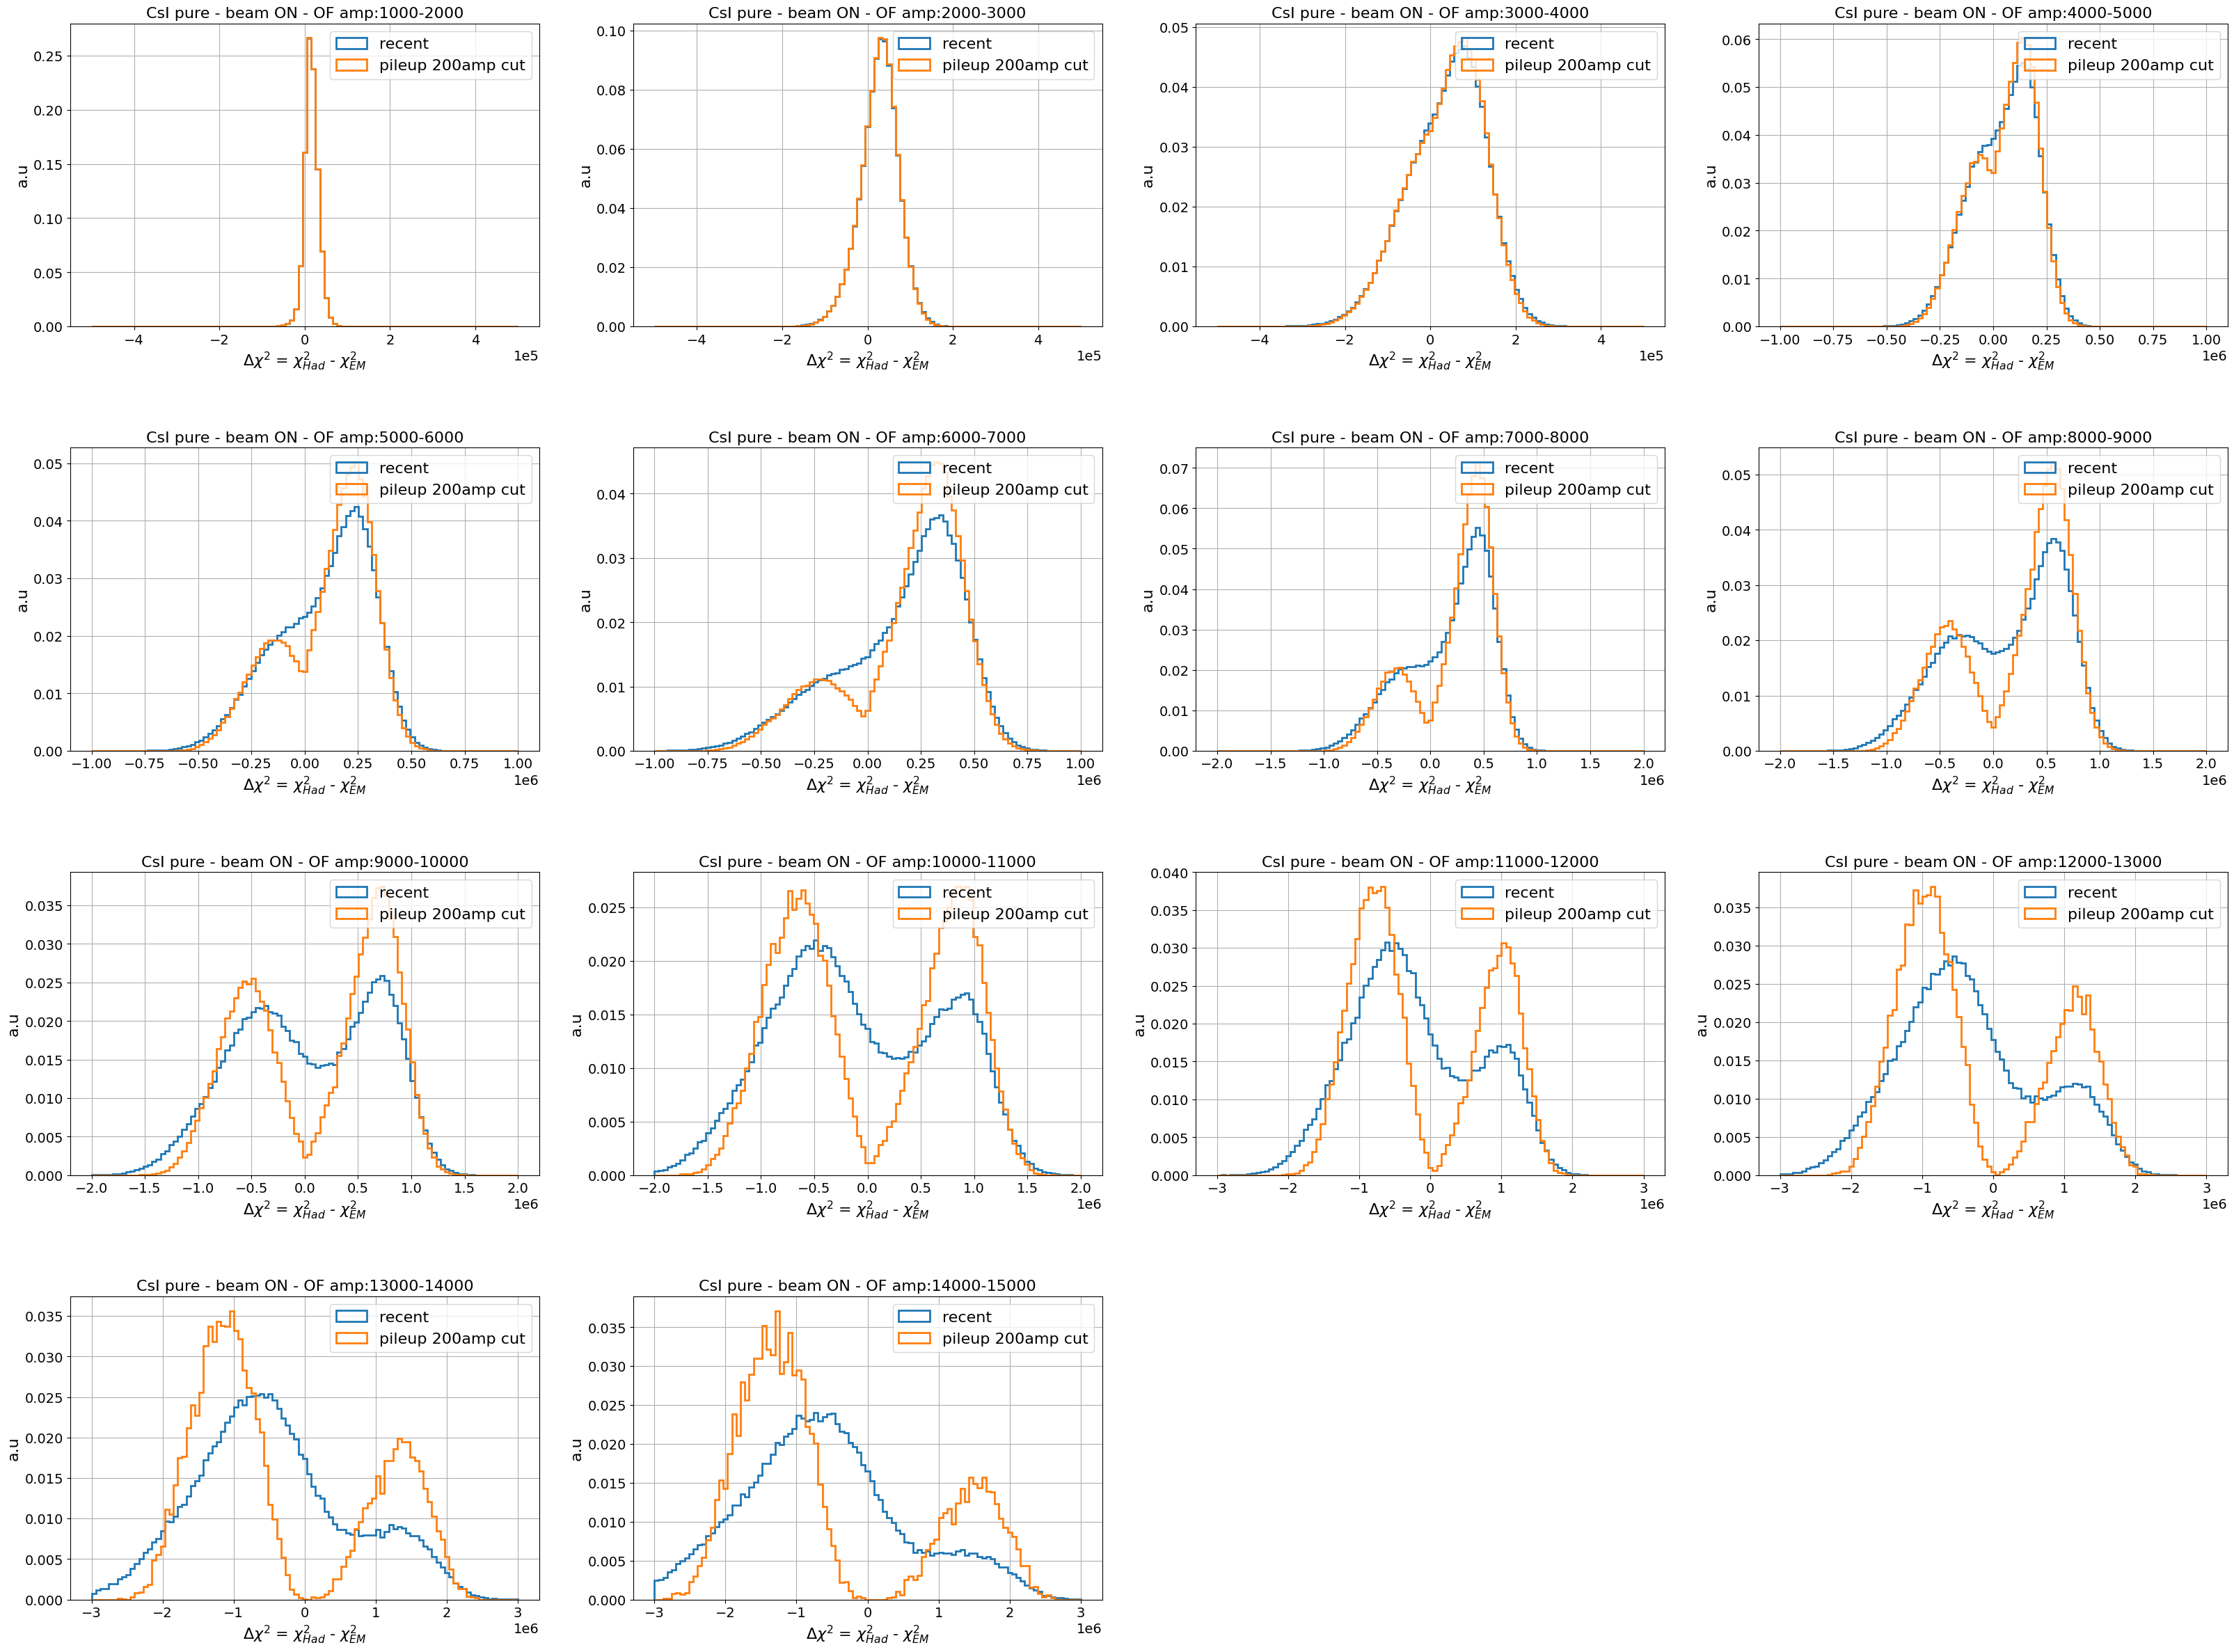

In [12]:



slices=np.arange(1000,15000,1000)
fig, ax = plt.subplots(4, 4, figsize=(40,30))
ax = ax.flatten()
ax[-1].axis('off'); ax[-2].axis('off')
for i, s in enumerate(slices):
    sl = [i for i, x in enumerate(XFEL_p_amp) if x>s and x<s+1000]
    if s  < 4000: bins = np.linspace(-0.5e6,0.5e6,100)
    elif s  < 7000: bins = np.linspace(-1e6,1e6,100)
    elif s  < 11000: bins = np.linspace(-2e6,2e6,100)
    else: bins = np.linspace(-3e6,3e6,100)
    weights = np.ones_like(np.take(XFEL_p_deltachi2,sl))/len(np.take(XFEL_p_deltachi2,sl))
    ax[i].hist(np.take(XFEL_p_deltachi2,sl), bins =bins, histtype = 'step', weights= weights, linewidth =2, label = 'recent')
    sl = [i for i, x in enumerate(XFEL_p_amp_1) if x>s and x<s+1000]
    if s  < 4000: bins = np.linspace(-0.5e6,0.5e6,100)
    elif s  < 7000: bins = np.linspace(-1e6,1e6,100)
    elif s  < 11000: bins = np.linspace(-2e6,2e6,100)
    else: bins = np.linspace(-3e6,3e6,100)
    weights = np.ones_like(np.take(XFEL_p_deltachi2_1,sl))/len(np.take(XFEL_p_deltachi2_1,sl))
    ax[i].hist(np.take(XFEL_p_deltachi2_1,sl), bins =bins, histtype = 'step', weights= weights, linewidth =2, label = 'pileup 200amp cut')
    ax[i].set_title('CsI pure - beam ON - OF amp:'+str(s)+'-'+str(s+1000))
    ax[i].set_xlabel(r'$\Delta\chi^2$ = $\chi^2_{Had}$ - $\chi^2_{EM}$')
    ax[i].set_ylabel('a.u')
    ax[i].grid()
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[i].legend()
plt.show()

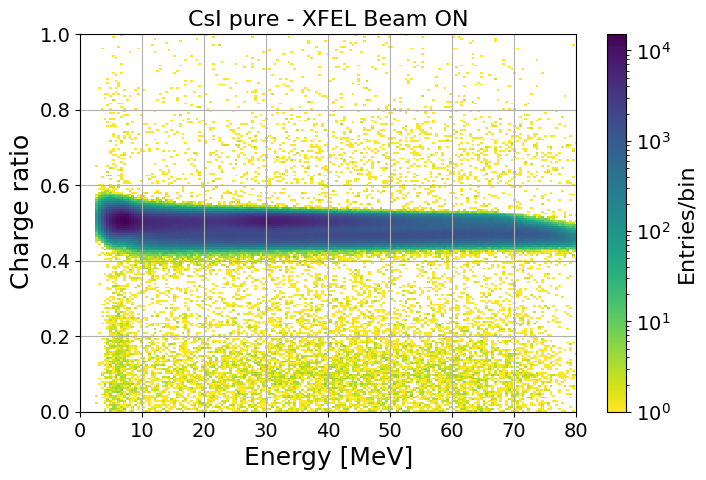

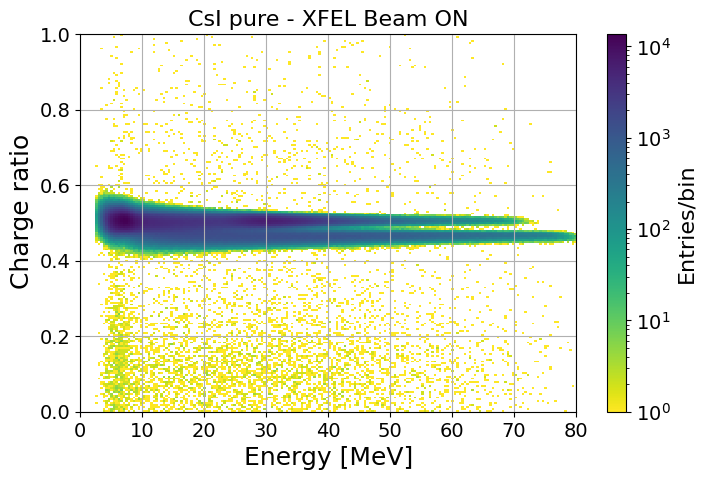

In [18]:
plt.figure(figsize=(8, 5))
plt.hist2d(Ecalibration(integrated_raw_amp_Tl_XFEL, 'pure'), CR_p_XFEL,bins=(200, np.linspace(0,1,200)),cmap='viridis_r', cmin=1, norm=LogNorm())
plt.xlabel(r'Energy [MeV]',fontsize=18)
plt.ylabel(r'   Charge ratio',fontsize=18)
plt.xlim(0,80)
plt.grid()
plt.title('CsI pure - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_Energy.png',bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.hist2d(Ecalibration(integrated_raw_amp_Tl_XFEL_1, 'pure'), CR_p_XFEL_1,bins=(200, np.linspace(0,1,200)),cmap='viridis_r', cmin=1, norm=LogNorm())
plt.xlabel(r'Energy [MeV]',fontsize=18)
plt.ylabel(r'   Charge ratio',fontsize=18)
plt.xlim(0,80)
plt.grid()
plt.title('CsI pure - XFEL Beam ON')
cbar = plt.colorbar()
cbar.set_label('Entries/bin')
# plt.savefig('../../../plots/beamON/DeltaChi2_p_XFEL_BeamON_Energy.png',bbox_inches = 'tight')
plt.show()

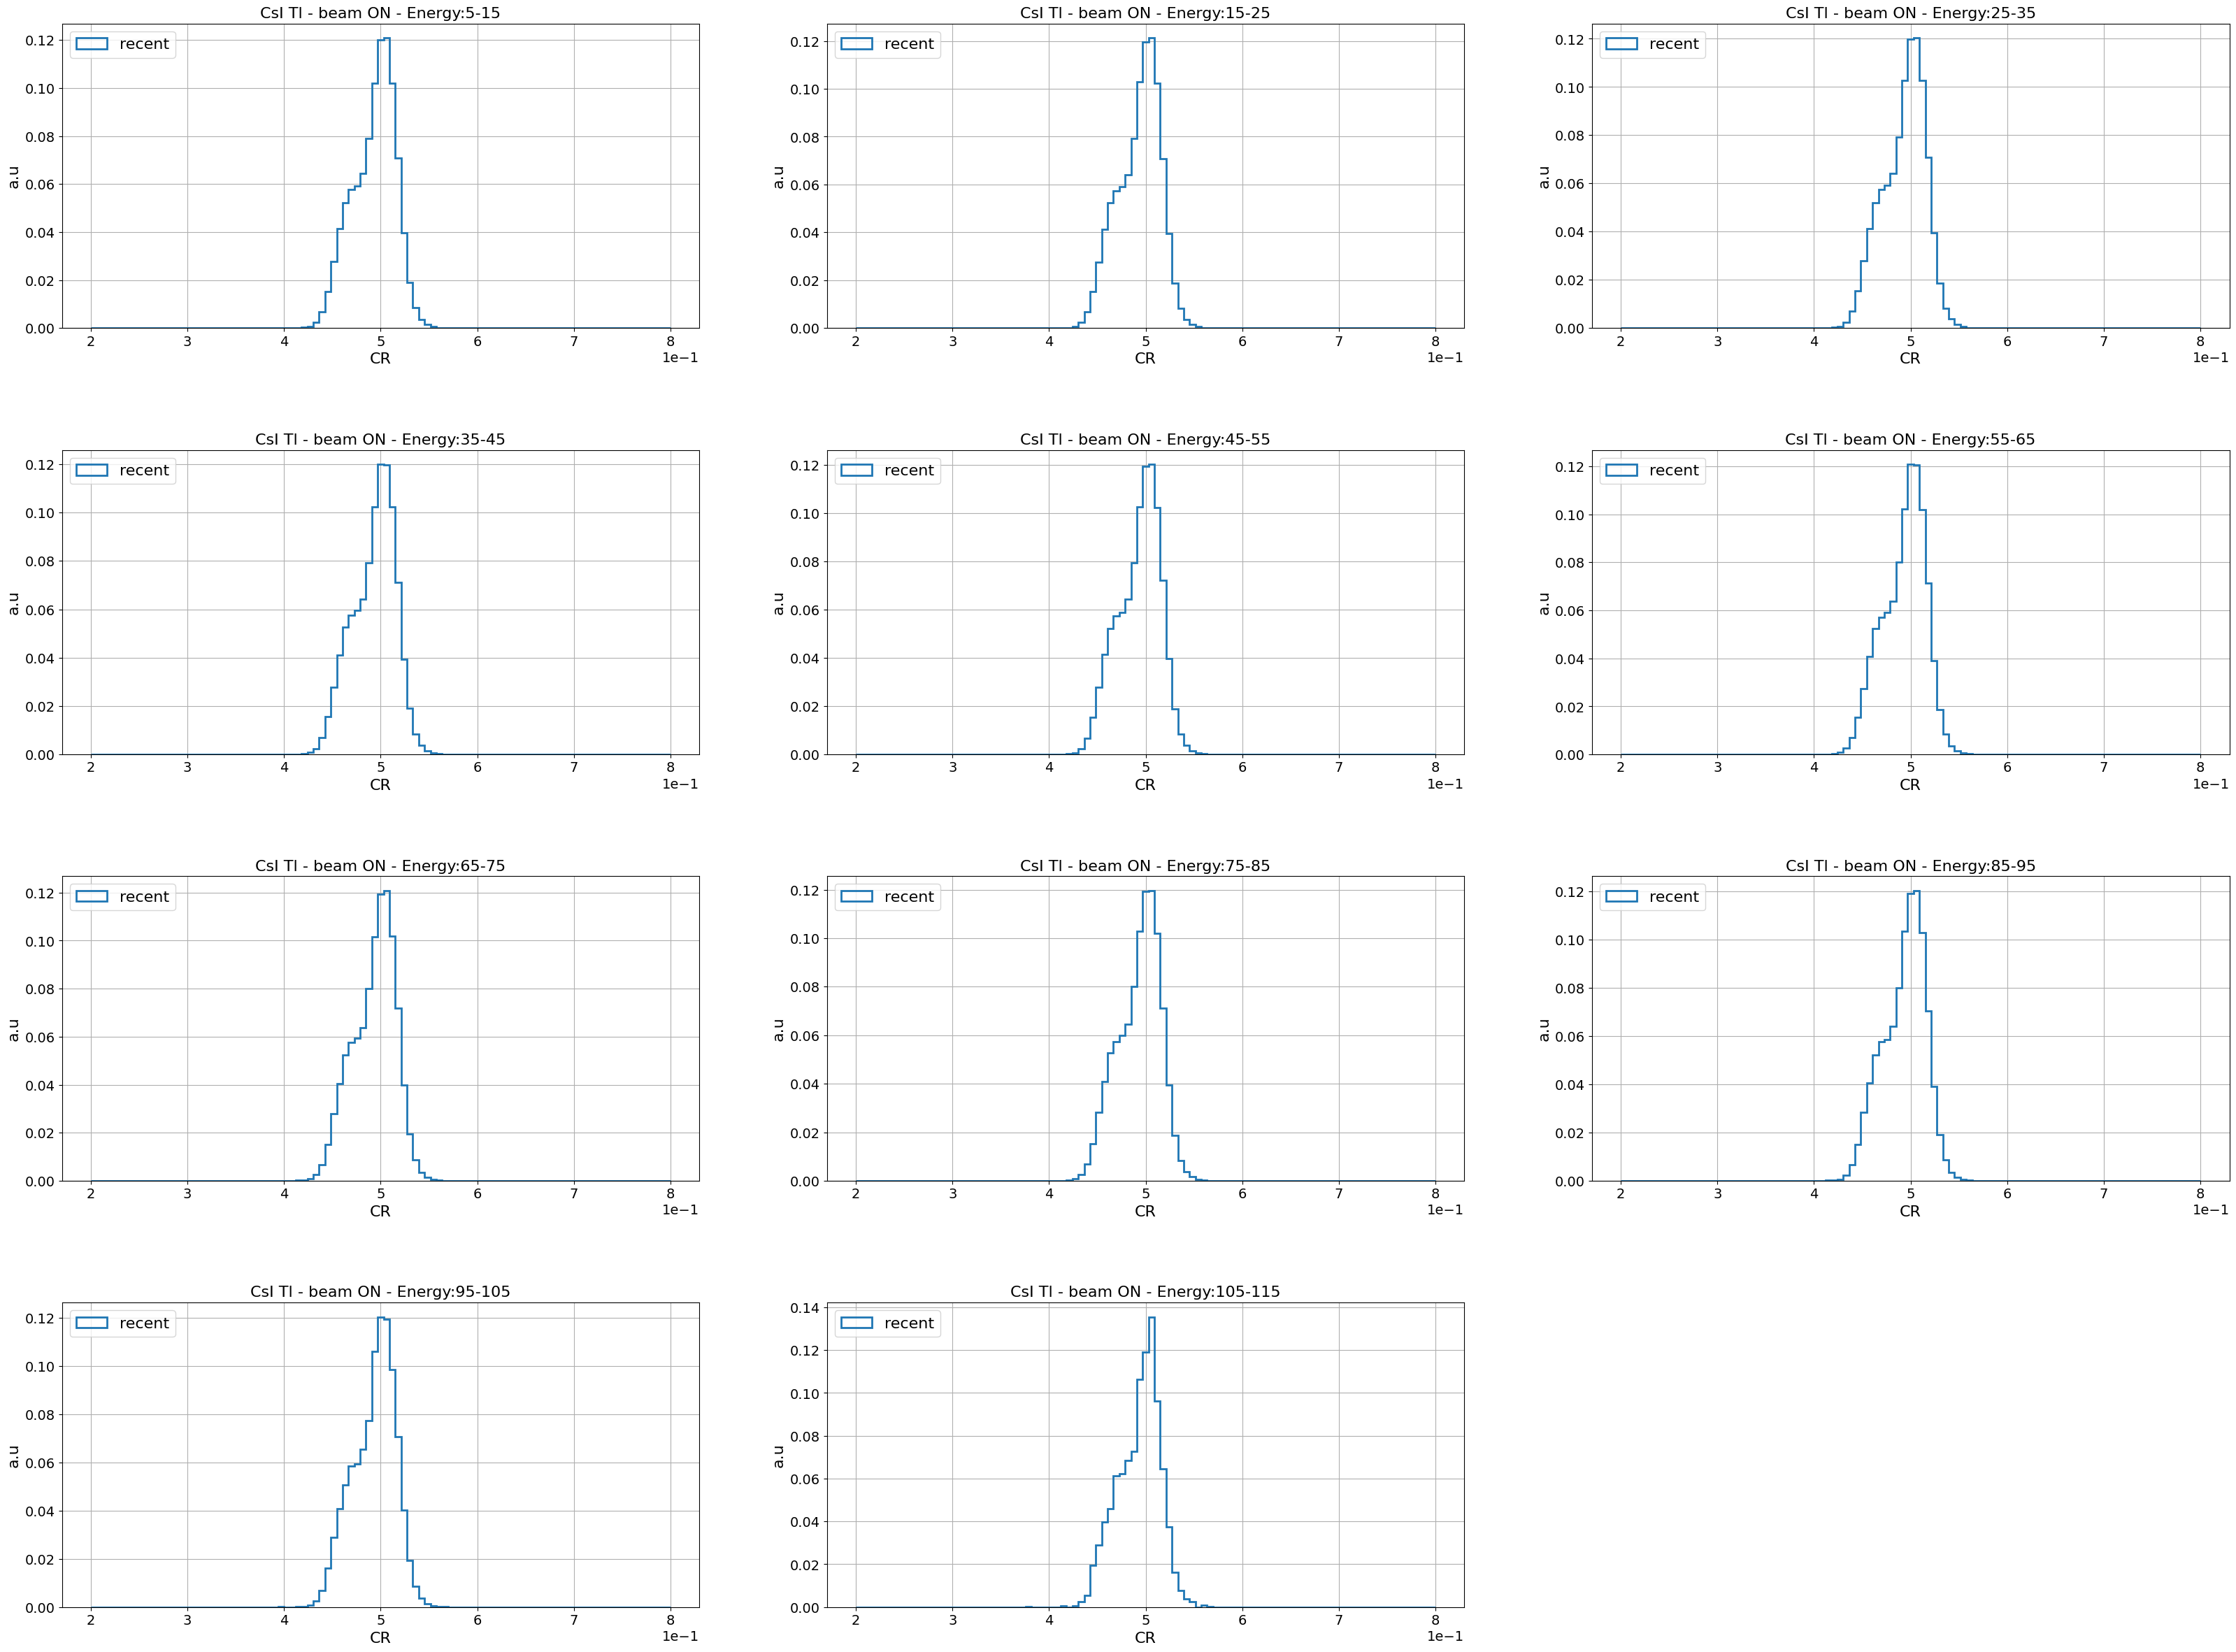

In [50]:


slices=np.arange(5,115,10)
fig, ax = plt.subplots(4, 3, figsize=(40,30))
ax = ax.flatten()
ax[-1].axis('off')
for i, s in enumerate(slices):
    sl = [i for i, x in enumerate(E) if x>s and x<s+10]
    bins = np.linspace(0.2,0.8,100)
#     if s  < 4000: bins = np.linspace(-0.3e8,0.3e8,100)
#     elif s  < 9000: bins = np.linspace(-0.7e8,0.7e8,100)
#     else: bins = np.linspace(-1.3e8,1.3e8,100)
    weights = np.ones_like(np.take(CR_p_XFEL,sl))/len(np.take(CR_p_XFEL,sl))
    ax[i].hist(np.take(CR_p_XFEL,sl), bins =bins,  histtype = 'step', weights = weights, linewidth = 2, label = 'recent')
    sl = [i for i, x in enumerate(XFEL_p_amp_1) if x>s and x<s+1000]
    weights = np.ones_like(np.take(XFEL_p_deltachi2_1,sl))/len(np.take(XFEL_p_deltachi2_1,sl))
#     ax[i].hist(np.take(XFEL_p_deltachi2_1,sl), bins =bins,  histtype = 'step', weights = weights, linewidth = 2, label = 'finetuned')
    ax[i].set_title('CsI Tl - beam ON - Energy:'+str(s)+'-'+str(s+10))
    ax[i].set_xlabel(r'CR')
    ax[i].set_ylabel('a.u')
    ax[i].grid()
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[i].legend(loc = 'upper left')
plt.show()